<a href="https://colab.research.google.com/github/Karsten-Yan/ky_facs_ai/blob/master/facs_ai_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fcsparser
!pip install scikit-plot

In [2]:
!apt install subversion

Reading package lists... Done
Building dependency tree       
Reading state information... Done
subversion is already the newest version (1.9.7-4ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [3]:
import fcsparser
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.mixture import GaussianMixture
from xgboost import XGBClassifier
import scikitplot as skplt
import matplotlib as mpl

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from umap import UMAP
from sklearn.manifold import TSNE

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
sns.set(style="white", palette="pastel", rc={"lines.linewidth": 2.5})

In [5]:
# some general parameters for plots
mpl.rcParams['axes.linewidth'] = 2.5
mpl.rcParams['axes.edgecolor'] = "grey"
mpl.rcParams['figure.edgecolor'] = "grey"
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['legend.edgecolor'] = "grey"
mpl.rcParams['legend.shadow'] = False
mpl.rcParams["legend.framealpha"] = 1
mpl.rcParams['font.weight'] = "bold"
mpl.rcParams['axes.labelweight'] = "bold"
mpl.rcParams['axes.titleweight'] = "bold"

# Data Import

In [6]:
# import data from github via svn
!svn checkout https://github.com/Karsten-Yan/ky_facs_ai/trunk/data/shedding/export

Checked out revision 20.


In [7]:
path = "/content/export"

In [8]:
genotype = ["WT","KO","KO","WT","WT","KO","WT","KO","WT"]
gt_dict = {idx:elm for idx,elm in enumerate(genotype)}

In [9]:
anti =["CD8","CD62L","CD3","IL6Ra","TNFa","unused","CD4","PacO"]
antibodies = ["pop","stim","mousenr","genotype","FSC_A","FSC_H","FSC_W","SSC_A","SSC_H","SSC_W"] + anti + ["time"]

In [10]:
#function for reading in multiple facs files
def read_fcs_data(path_sub, gt_dict, antibodies):
    
    df = pd.DataFrame()
    #loop through every file
    for elm in os.listdir(path_sub):
        # only take fcs files      
        if elm.endswith(".fcs"):
          temp_df = pd.DataFrame()
          file = os.path.join(path_sub, elm)

          # parse facs data with fcs parser
          meta, data = fcsparser.parse(file, meta_data_only=False, reformat_meta=True)
          # split file name into components
          elm_split = elm.split("_")
          # split first component again to get population and stimulation info
          # append them to the whole data frame
          split_first = elm_split[0].split(" ")
          temp_df["pop"] = [split_first[-1]]*len(data)
          temp_df["stim"] = [split_first[1]]*len(data)

          # get mouse nr from file name element 2
          int_list = list(elm_split[2])
          gt = int(int_list[2])
          temp_df["mousenr"] = [gt]*len(data)
          # get genotype from mouse nr and genotype dict
          temp_df["genotype"]=[gt_dict[gt-1]]*len(data)

          #concatenate fcs data with prepared meta data
          temp_df = pd.concat([temp_df, data],axis=1)
          
          #concatenate every temp_df prepared by every step of the loop with root df
          df = pd.concat([df, temp_df],axis=0)
    
    # change some cols to categorical to save memory
    df["genotype"] = df["genotype"].astype("category")
    df["pop"] = df["pop"].astype("category")
    df["mousenr"] = df["mousenr"].astype("category")

    # rename columns
    df.columns = antibodies
    df.reset_index(inplace=True)

    # drop unimportant columns
    df.drop("time",inplace=True,axis=1)
    df.drop("index",inplace=True,axis=1)
    df.drop("unused",inplace=True,axis=1)
    df.drop("PacO",inplace=True,axis=1)   
    return df
    

In [11]:
df = read_fcs_data(path, gt_dict, antibodies)

# EDA

In [12]:
numeric_features = list(df.columns[df.dtypes ==  "float32"])
gating_features = ["CD4","CD8"]

In [13]:
# outlier removal based on z score

z = np.abs(stats.zscore(df[numeric_features]))
dfo = df[(z < 11).all(axis=1)].copy()

# Gating and EDA

In [14]:
seed=42

In [15]:
gating=GaussianMixture(3,random_state=seed,covariance_type="full",max_iter=1000,tol = 10)
dfo["label_unmapped"] = gating.fit_predict(dfo[gating_features])

In [16]:
def facs_plot( stim,pop,mousenr,x,y,c=None,df=dfo):
    fig, ax = plt.subplots(1,1,figsize=(8,8))
    temp_df = df[(df["mousenr"]==mousenr)&(df["pop"]==pop)&(df["stim"]==stim)].sample(frac=0.01)
    ax = sns.scatterplot(data=temp_df, x=x,y=y,hue=c)
    ax.set_xscale("symlog",linthreshx=100,linscalex=0.2)
    ax.set_yscale("symlog",linthreshy=100,linscaley=0.2)
    ax.set_xlim(-1000,300000)
    ax.set_ylim(-1000,300000)
    
    return ax

In [17]:
xtoggle = widgets.ToggleButtons(options=anti[:5]+[anti[6]], description="Y Axis",value="CD4")
ytoggle = widgets.ToggleButtons(options=anti[:5]+[anti[6]], description="X Axis",value="CD8")
poptoggle = widgets.ToggleButtons(options=list(df["pop"].unique()),description="pop",value="Without")
stimtoggle = widgets.ToggleButtons(options=list(df["stim"].unique()),description="stim",value="Unstimulated")
labeltoggle = widgets.ToggleButtons(options=["label","label_unmapped"],description="hue",value="label_unmapped")

mousenr = widgets.BoundedIntText(min=1,max=np.max(df.mousenr.unique().as_ordered()), description = "mousenr")

out = widgets.interactive_output(facs_plot, {"mousenr":mousenr, "x":xtoggle, "y":ytoggle,"pop":poptoggle,"stim":stimtoggle,"c":labeltoggle})
display(mousenr,xtoggle,ytoggle,poptoggle,stimtoggle,labeltoggle,out)

BoundedIntText(value=1, description='mousenr', max=6, min=1)

ToggleButtons(description='Y Axis', index=5, options=('CD8', 'CD62L', 'CD3', 'IL6Ra', 'TNFa', 'CD4'), value='C…

ToggleButtons(description='X Axis', options=('CD8', 'CD62L', 'CD3', 'IL6Ra', 'TNFa', 'CD4'), value='CD8')

ToggleButtons(description='pop', index=2, options=('GI', 'GW', 'Without'), value='Without')

ToggleButtons(description='stim', index=1, options=('stimulated', 'Unstimulated'), value='Unstimulated')

ToggleButtons(description='hue', index=1, options=('label', 'label_unmapped'), value='label_unmapped')

Output()

In [18]:
map_dict={2:"rest",0:"CD4TCells",1:"CD8TCells"}
dfo["label"]=dfo["label_unmapped"].map(map_dict)

In [19]:
dfo["label2"] = dfo["pop"].astype("str")+"_"+dfo["stim"].astype("str")+"_"+dfo["genotype"].astype("str")
dfo["label2"] = dfo["label2"].astype("category")

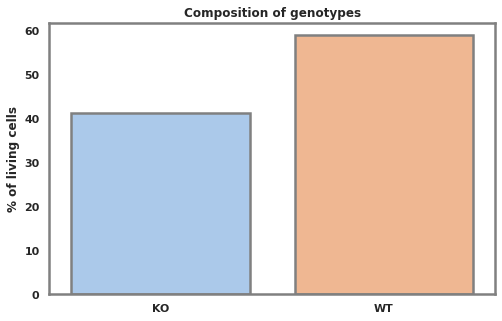

In [20]:
plt.figure(figsize=(8,5))
geno_data = dfo["genotype"].value_counts()
geno_data = (geno_data/geno_data.sum())*100
geno_data = geno_data.reset_index().sort_values("index")
sns.barplot(y = geno_data["genotype"],x=geno_data["index"], edgecolor="grey",linewidth=2.5)
plt.title("Composition of genotypes")
plt.ylabel("% of living cells")
plt.xlabel("");

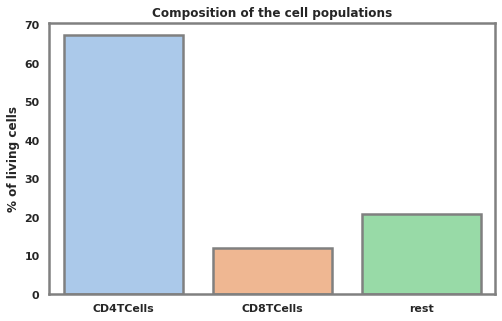

In [60]:
plt.figure(figsize=(8,5))
pop_data = dfo["label"].value_counts()
pop_data = (pop_data/pop_data.sum())*100
pop_data = pop_data.reset_index().sort_values("index")
ax1 = sns.barplot(y = pop_data["label"],x=pop_data["index"], edgecolor="grey",linewidth=2.5)
plt.title("Composition of the cell populations")
plt.ylabel("% of living cells")
plt.xlabel("");

# DR analysis

In [22]:
df_unsup = pd.concat([dfo[(dfo["genotype"]=="WT")&(dfo["stim"] == "stimulated")&(dfo["pop"]=="Without")].sample(12500),
                      dfo[(dfo["genotype"]=="KO")&(dfo["stim"] == "stimulated")&(dfo["pop"]=="Without")].sample(12500)], axis=0)
df_unsup_unstim = pd.concat([dfo[(dfo["genotype"]=="WT")&(dfo["stim"] == "Unstimulated")&(dfo["pop"]=="Without")].sample(12500),
                      dfo[(dfo["genotype"]=="KO")&(dfo["stim"] == "Unstimulated")&(dfo["pop"]=="Without")].sample(12500)], axis=0)

In [23]:
drr_features = set(numeric_features).intersection( set(anti))

In [24]:
def drr_plot(df,name,hue):
    fig,ax = plt.subplots(1,3,figsize=(20,7))
    sns.scatterplot(x=name+"_dim_2", y=name+"_dim_1", data = df,hue=hue, 
                    ax=ax[0], hue_norm=(0,1000), palette="viridis")
    sns.scatterplot(x=name+"_dim_2", y=name+"_dim_1", data = df[df["genotype"]=="KO"],hue=hue, 
                    ax=ax[1], hue_norm=(0,1000), palette="viridis")
    sns.scatterplot(x=name+"_dim_2", y=name+"_dim_1", data = df[df["genotype"]=="WT"],hue=hue, 
                    ax=ax[2], hue_norm=(0,1000), palette="viridis")

    ax[0].set_title("Both Genotypes")
    ax[0].set_xlabel("")
    ax[0].set_ylabel("")
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].get_legend().remove()
    ax[1].set_title("Knockout")
    ax[1].set_xlabel("")
    ax[1].set_ylabel("")
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].get_legend().remove()
    ax[2].set_title("Wildtype")
    ax[2].set_xlabel("")
    ax[2].set_ylabel("")
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    ax[2].get_legend().remove()
    plt.suptitle(name + " Analysis "+hue)

## UMAP

[Bokeh Visualisation (Heroku)](https://umap-bokeh.herokuapp.com/)

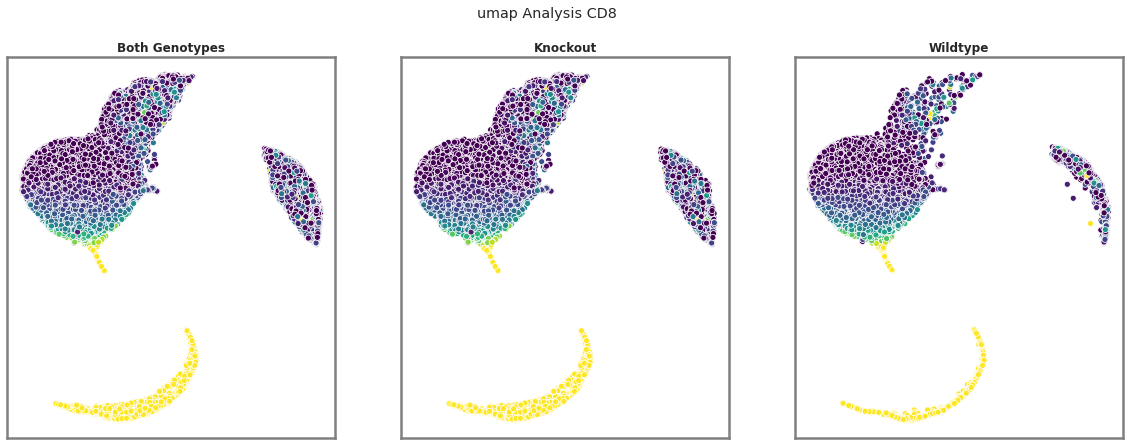

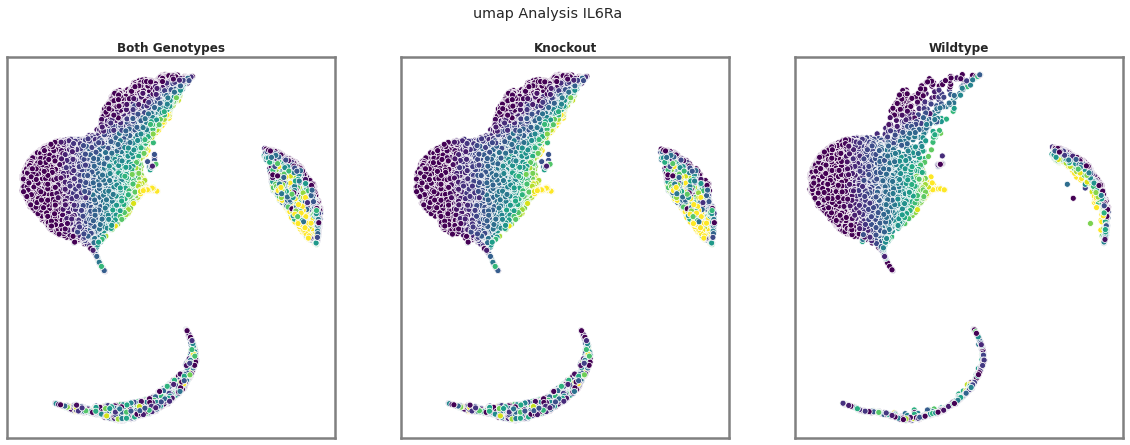

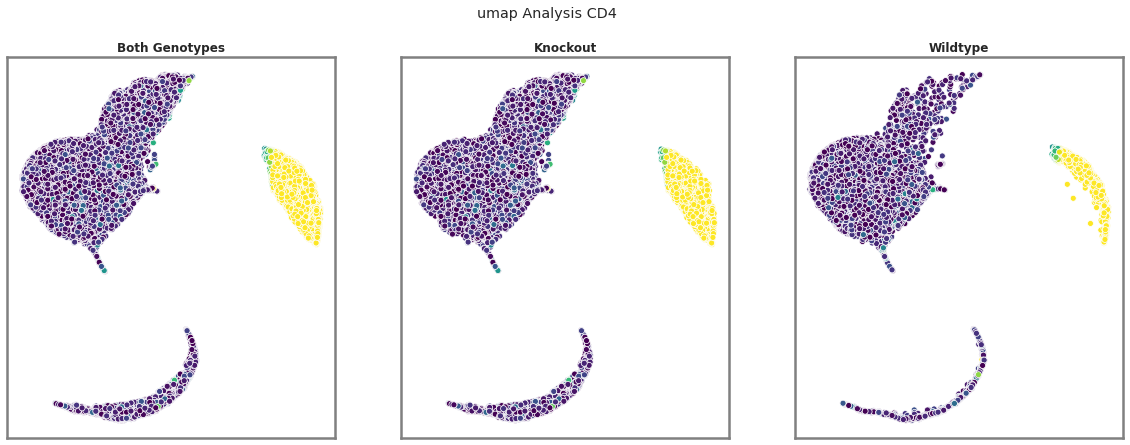

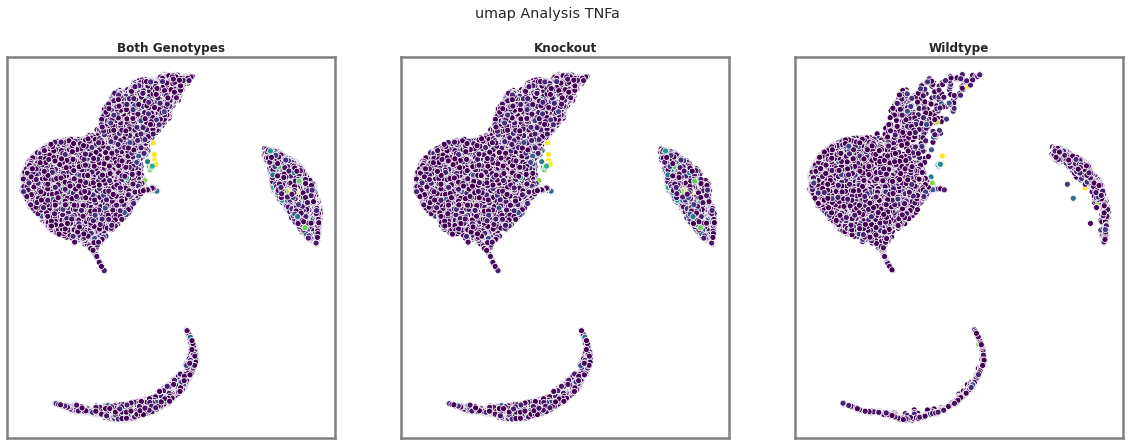

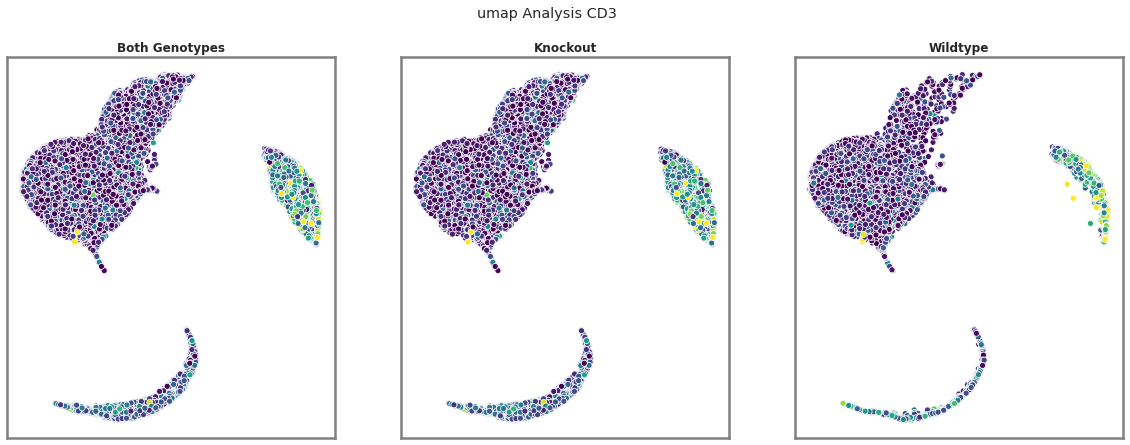

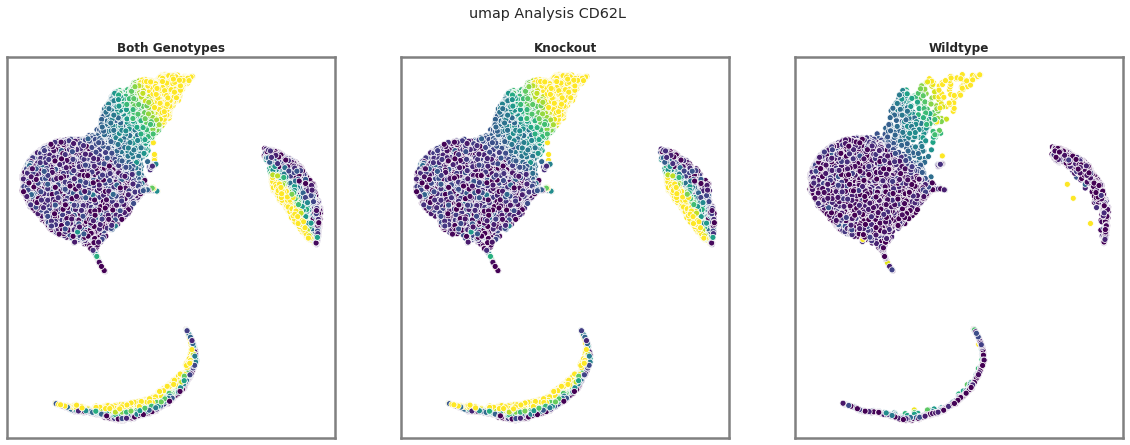

In [25]:
umap = UMAP(n_neighbors=40)
umap_dims = umap.fit_transform(df_unsup[drr_features])
umap_df = pd.DataFrame(umap_dims)
umap_df.columns = ["umap_dim_1","umap_dim_2"]
umap_df = pd.concat([umap_df, df_unsup.reset_index()],axis=1)

for elm in drr_features:
    drr_plot(umap_df,"umap",elm)

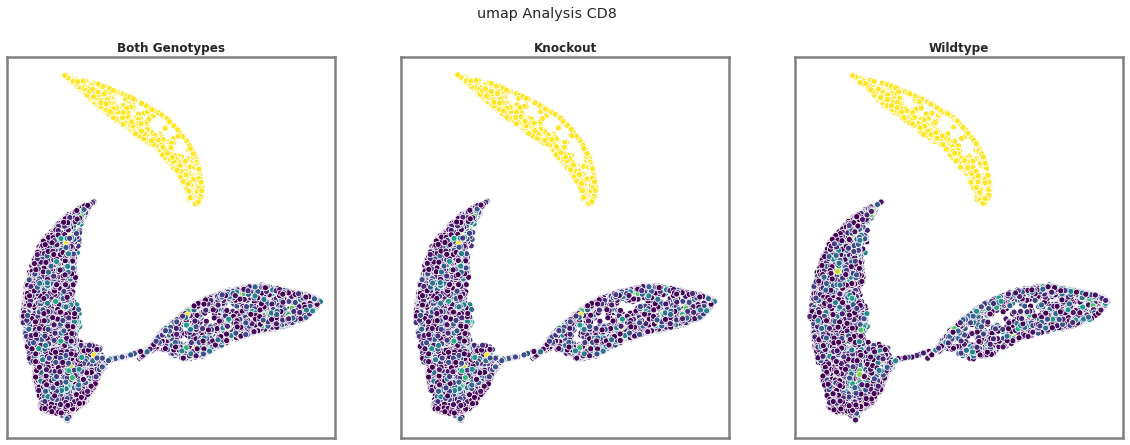

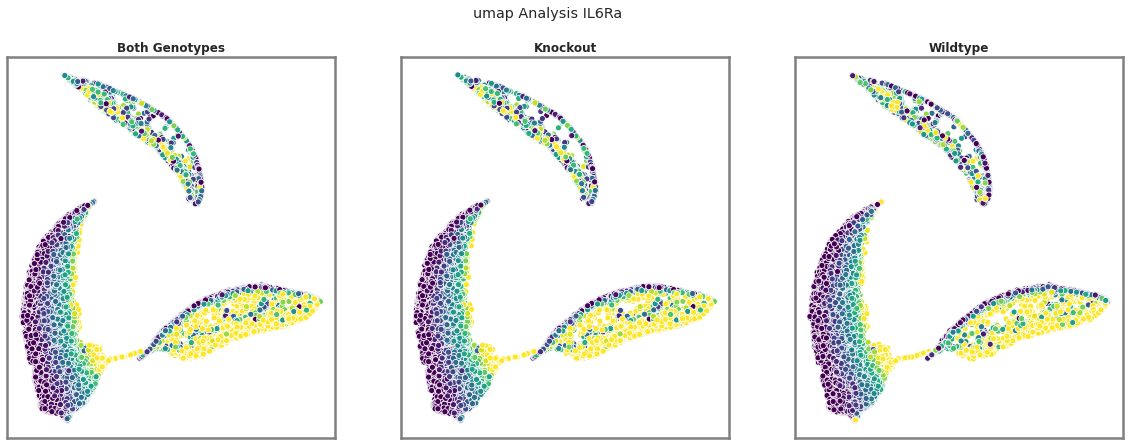

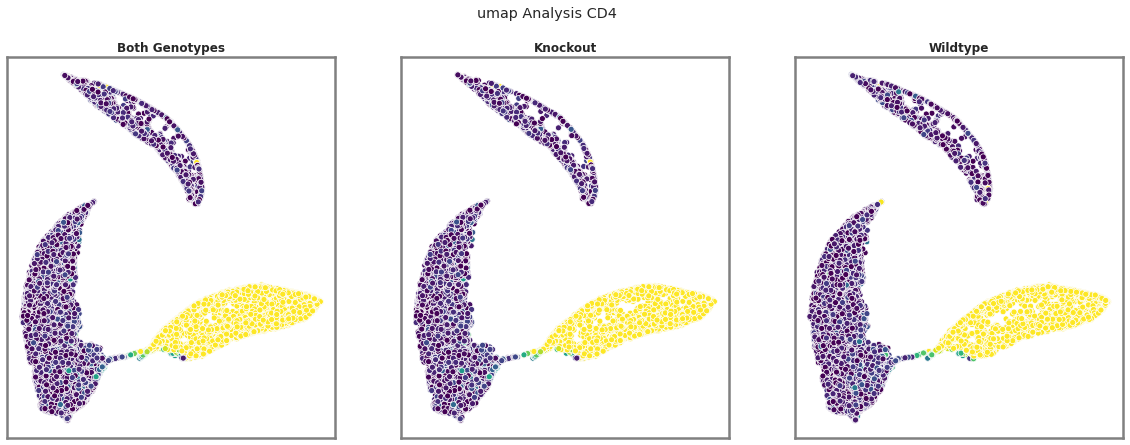

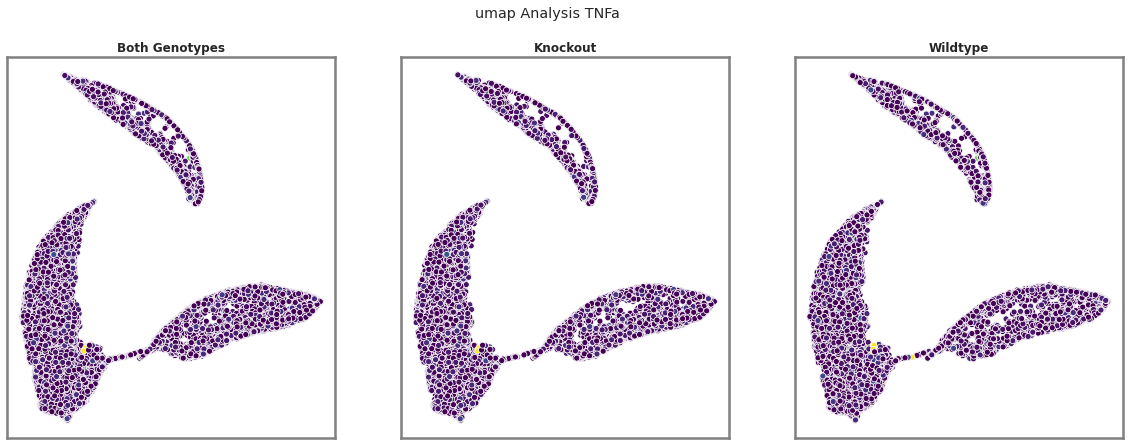

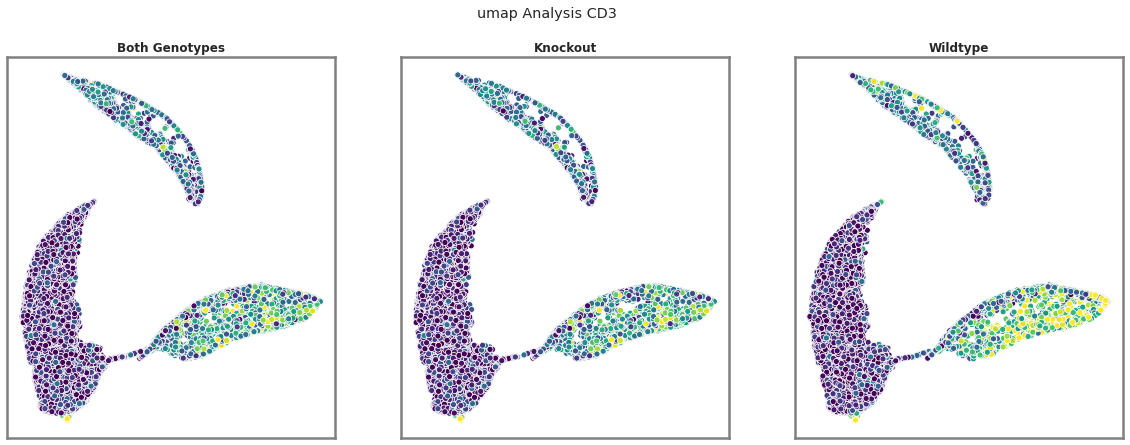

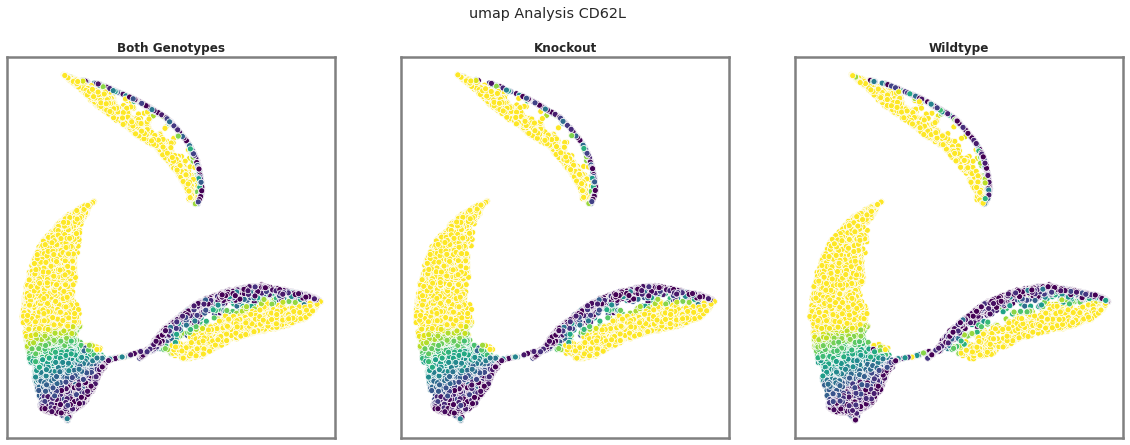

In [26]:
umap_unstim = UMAP(n_neighbors=40)
umap_dims_unstim = umap_unstim.fit_transform(df_unsup_unstim[drr_features])
umap_df_unstim = pd.DataFrame(umap_dims_unstim)
umap_df_unstim.columns = ["umap_dim_1","umap_dim_2"]
umap_df_unstim = pd.concat([umap_df_unstim, df_unsup_unstim.reset_index()],axis=1)

for elm in drr_features:
    drr_plot(umap_df_unstim,"umap",elm)

# predictive modelling

In [56]:
def pop_model(df,gt,pop,x_list, y_label, model, top=3):
    konr = df[df["genotype"]==gt[0]]["mousenr"].unique()
    wtnr = df[df["genotype"]==gt[1]]["mousenr"].unique()
    
    df_train = df[df["mousenr"].isin(konr[:-1])|df["mousenr"].isin(wtnr[:-1])]
    df_val = df[df["mousenr"].isin(konr[-1:])|df["mousenr"].isin(wtnr[-1:])]
  
    df_pop_train = df_train[df_train["label"] == pop]
    df_pop_val = df_val[df_val["label"] == pop]
    
    X_train = df_pop_train[x_list]
    y_train = df_pop_train[y_label]
    X_val = df_pop_val[x_list]
    y_val = df_pop_val[y_label]
    
    model.fit(X_train, y_train)

    classes = model.classes_
    labels = ["\n".join(elm.split("_")) for elm in classes]
    
    y_pred = model.predict(X_val)

    fig, axs = plt.subplots(1,2,figsize=(10,5))
    
    skplt.metrics.plot_confusion_matrix(y_val, y_pred, text_fontsize=10, normalize = True, ax = axs[0])
    axs[0].set_yticklabels(labels=labels)
    axs[0].set_xticklabels(labels=labels)
    axs[0].images[-1].colorbar.remove()
    
    skplt.estimators.plot_feature_importances(model, feature_names=x_list,max_num_features=20, ax = axs[1])
    fig.set_edgecolor("grey")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show();
    
    fimp = sorted([(elm,numeric_features[idx]) for idx,elm in enumerate(model.feature_importances_)],reverse=True)
    
    fig, axs = plt.subplots(1,top,figsize=(9,3))
    for i in range(top):
        sns.barplot(x = df_pop_train.genotype.astype("object"), y = df_pop_train[fimp[i][1]], ax = axs[i], hue_order = ["WT","KO"], edgecolor="grey",linewidth=2.5)
    plt.tight_layout()
    plt.suptitle("Top "+str(top)+" important features",fontweight="bold")
    plt.subplots_adjust(top=0.9,hspace = 0)
    plt.show()
    
    print("-"*20+"Classification Report"+"-"*20)
    print(classification_report(y_val, y_pred))

## CD8

### CD8 without

In [57]:
df_sup_wo = dfo[(dfo["stim"] == "stimulated")&(dfo["pop"]=="Without")]

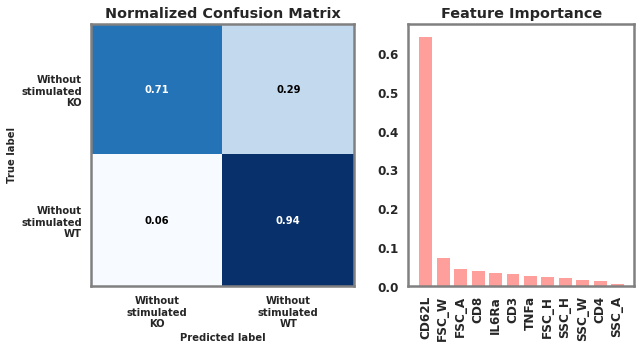

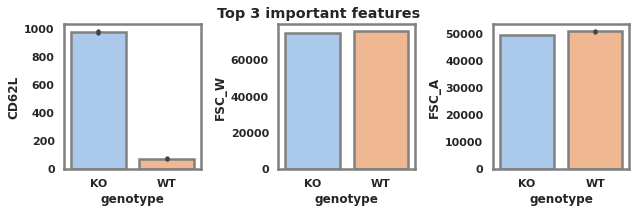

--------------------Classification Report--------------------
                       precision    recall  f1-score   support

Without_stimulated_KO       0.92      0.71      0.80     10730
Without_stimulated_WT       0.75      0.94      0.83     10010

             accuracy                           0.82     20740
            macro avg       0.84      0.82      0.82     20740
         weighted avg       0.84      0.82      0.82     20740



In [58]:
xgb_clf_cd8_wo = XGBClassifier(n_jobs = -1,random_state=42)
pop_model(df_sup_wo,["WT","KO"],"CD8TCells",numeric_features, "label2", xgb_clf_cd8_wo,3)

### CD8 GI

In [30]:
df_sup_gi = dfo[(dfo["stim"] == "stimulated")&(dfo["pop"]=="GI")]

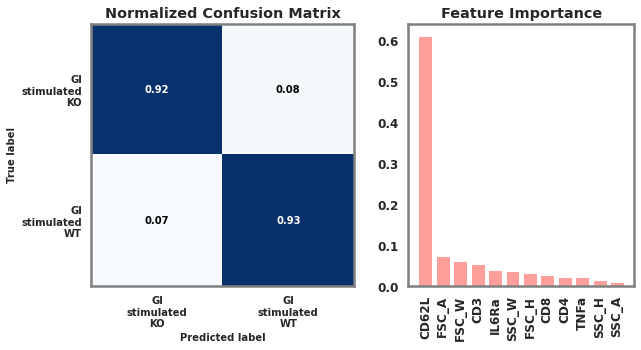

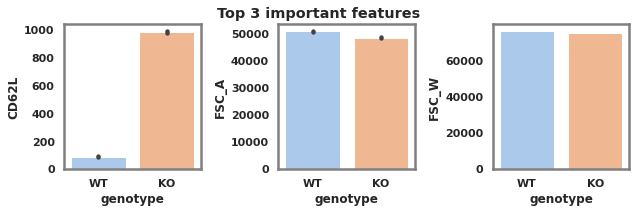

--------------------Classification Report--------------------
                  precision    recall  f1-score   support

GI_stimulated_KO       0.93      0.92      0.92     12732
GI_stimulated_WT       0.92      0.93      0.92     12723

        accuracy                           0.92     25455
       macro avg       0.92      0.92      0.92     25455
    weighted avg       0.92      0.92      0.92     25455



In [31]:
xgb_clf_cd8_gi = XGBClassifier(n_jobs = -1,random_state=42)
pop_model(df_sup_gi,["WT","KO"],"CD8TCells",numeric_features, "label2", xgb_clf_cd8_gi,3)

### CD8 gw

In [32]:
df_sup_gw = dfo[(dfo["stim"] == "stimulated")&(dfo["pop"]=="GW")]

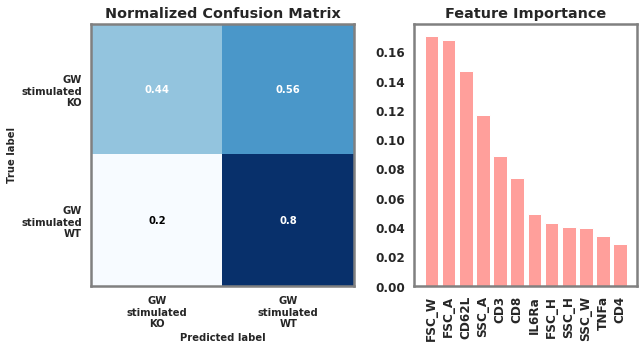

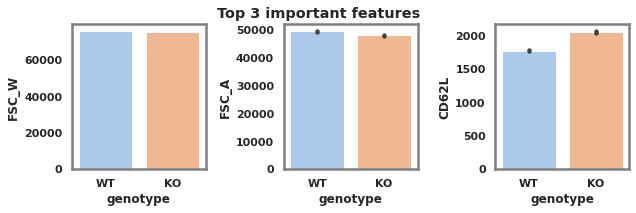

--------------------Classification Report--------------------
                  precision    recall  f1-score   support

GW_stimulated_KO       0.75      0.44      0.56     12658
GW_stimulated_WT       0.52      0.80      0.63      9442

        accuracy                           0.60     22100
       macro avg       0.64      0.62      0.59     22100
    weighted avg       0.65      0.60      0.59     22100



In [33]:
xgb_clf_cd8_gw = XGBClassifier(n_jobs = -1,random_state=42)
pop_model(df_sup_gw,["WT","KO"],"CD8TCells",numeric_features, "label2", xgb_clf_cd8_gw,3)

## CD4

### CD4 without

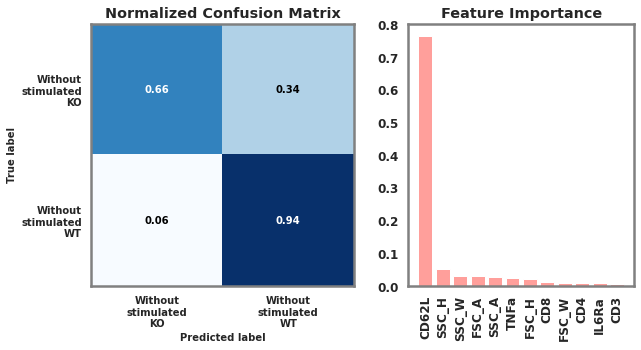

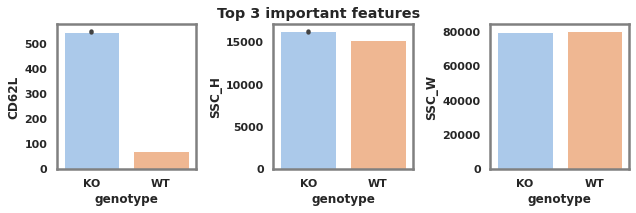

--------------------Classification Report--------------------
                       precision    recall  f1-score   support

Without_stimulated_KO       0.84      0.66      0.74     81868
Without_stimulated_WT       0.85      0.94      0.89    165580

             accuracy                           0.85    247448
            macro avg       0.84      0.80      0.81    247448
         weighted avg       0.84      0.85      0.84    247448



In [34]:
xgb_clf_cd4_wo = XGBClassifier(n_jobs = -1,random_state=42)
pop_model(df_sup_wo,["WT","KO"],"CD4TCells",numeric_features, "label2", xgb_clf_cd4_wo,3)

### CD4 GI

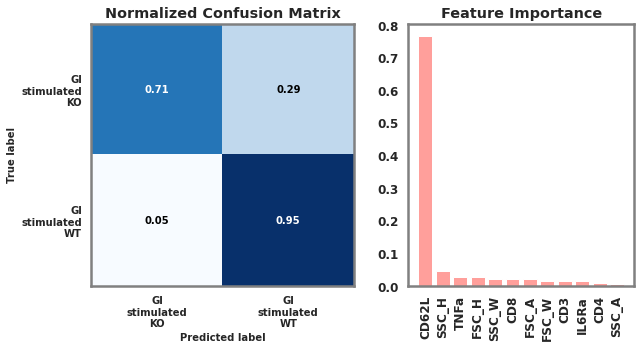

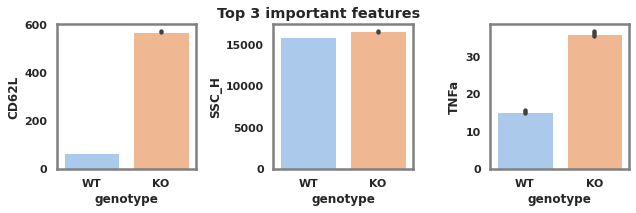

--------------------Classification Report--------------------
                  precision    recall  f1-score   support

GI_stimulated_KO       0.94      0.71      0.81     72831
GI_stimulated_WT       0.77      0.95      0.85     71050

        accuracy                           0.83    143881
       macro avg       0.85      0.83      0.83    143881
    weighted avg       0.85      0.83      0.83    143881



In [35]:
xgb_clf_cd4_gi = XGBClassifier(n_jobs = -1,random_state=42)
pop_model(df_sup_gi,["WT","KO"],"CD4TCells",numeric_features, "label2", xgb_clf_cd4_gi,3)

### CD4 gw

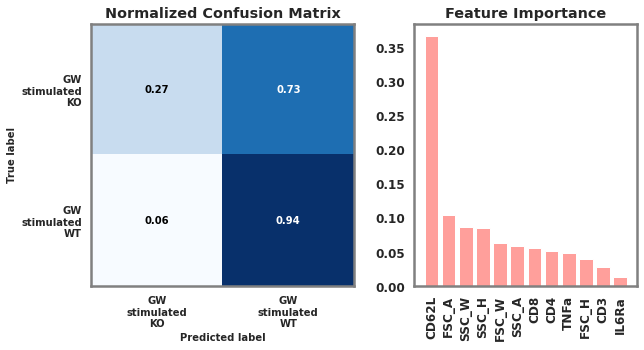

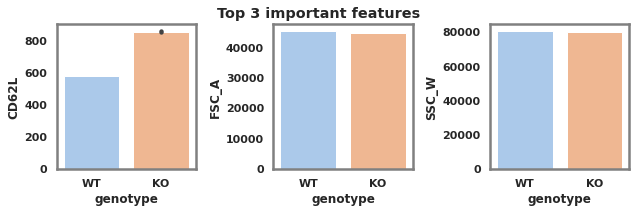

--------------------Classification Report--------------------
                  precision    recall  f1-score   support

GW_stimulated_KO       0.69      0.27      0.38     71934
GW_stimulated_WT       0.72      0.94      0.82    144977

        accuracy                           0.72    216911
       macro avg       0.71      0.60      0.60    216911
    weighted avg       0.71      0.72      0.67    216911



In [36]:
xgb_clf_cd4_gw = XGBClassifier(n_jobs = -1,random_state=42)
pop_model(df_sup_gw,["WT","KO"],"CD4TCells",numeric_features, "label2", xgb_clf_cd4_gw,3)

## rest

### rest without

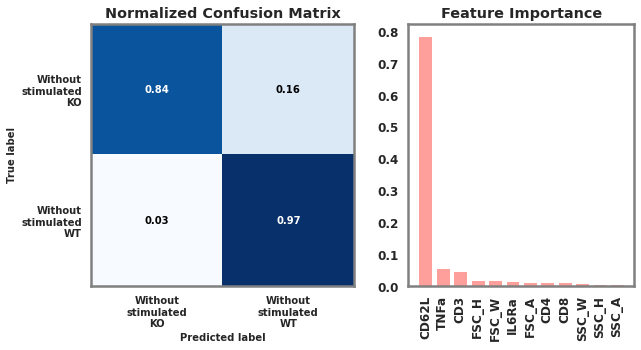

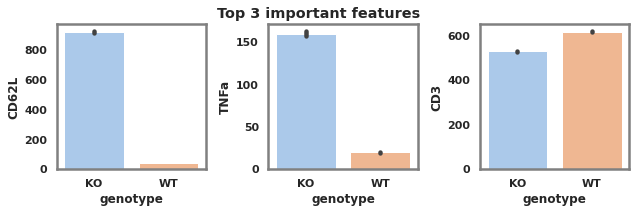

--------------------Classification Report--------------------
                       precision    recall  f1-score   support

Without_stimulated_KO       0.98      0.84      0.90     15229
Without_stimulated_WT       0.82      0.97      0.89     11796

             accuracy                           0.90     27025
            macro avg       0.90      0.91      0.90     27025
         weighted avg       0.91      0.90      0.90     27025



In [37]:
xgb_clf_rest_wo = XGBClassifier(n_jobs = -1,random_state=42)
pop_model(df_sup_wo,["WT","KO"],"rest",numeric_features, "label2", xgb_clf_rest_wo,3)

### rest GI

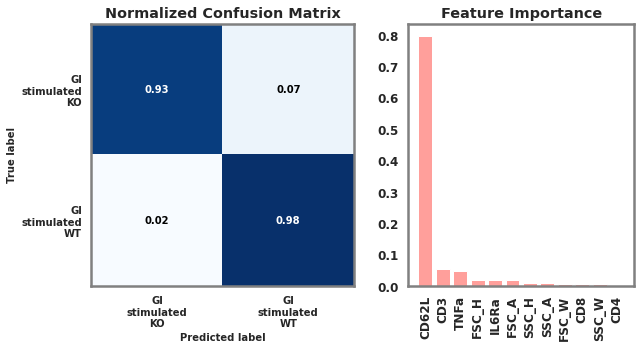

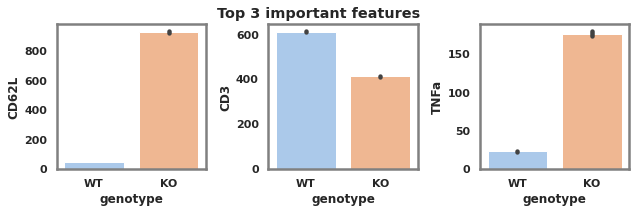

--------------------Classification Report--------------------
                  precision    recall  f1-score   support

GI_stimulated_KO       0.97      0.93      0.95     17394
GI_stimulated_WT       0.94      0.98      0.96     20541

        accuracy                           0.96     37935
       macro avg       0.96      0.95      0.96     37935
    weighted avg       0.96      0.96      0.96     37935



In [38]:
xgb_clf_rest_gi = XGBClassifier(n_jobs = -1,random_state=42)
pop_model(df_sup_gi,["WT","KO"],"rest",numeric_features, "label2", xgb_clf_rest_gi,3)

### rest gw

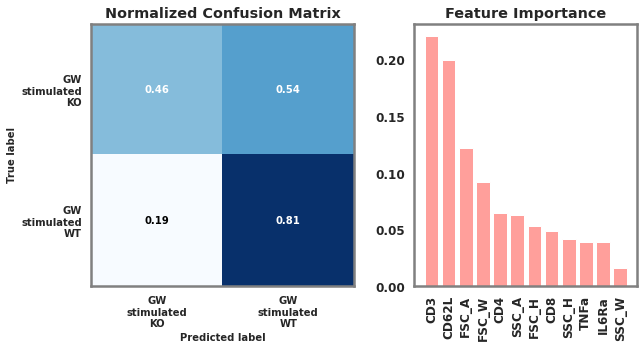

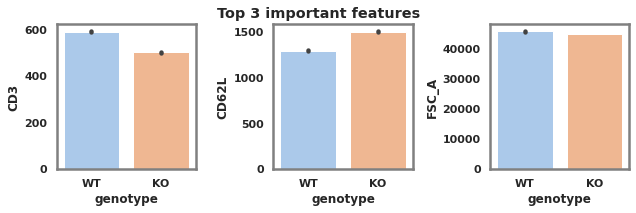

--------------------Classification Report--------------------
                  precision    recall  f1-score   support

GW_stimulated_KO       0.83      0.46      0.59     23775
GW_stimulated_WT       0.41      0.81      0.55     11297

        accuracy                           0.57     35072
       macro avg       0.62      0.63      0.57     35072
    weighted avg       0.70      0.57      0.58     35072



In [39]:
xgb_clf_rest_gw = XGBClassifier(n_jobs = -1,random_state=42)
pop_model(df_sup_gw,["WT","KO"],"rest",numeric_features, "label2", xgb_clf_rest_gw,3)

## all cells

In [68]:
df_test_wo = dfo[(dfo["stim"] == "stimulated")&(dfo["pop"]=="Without")]

In [69]:
def pop_model2(df,gt,pop,x_list, y_label, model, top=3):
    konr = df[df["genotype"]==gt[0]]["mousenr"].unique()
    wtnr = df[df["genotype"]==gt[1]]["mousenr"].unique()
    
    df_train = df[df["mousenr"].isin(konr[:-1])|df["mousenr"].isin(wtnr[:-1])]
    df_val = df[df["mousenr"].isin(konr[-1:])|df["mousenr"].isin(wtnr[-1:])]
  
    df_pop_train = df_train.copy()
    df_pop_val = df_val.copy()
    
    X_train = df_pop_train[x_list]
    y_train = df_pop_train[y_label]
    X_val = df_pop_val[x_list]
    y_val = df_pop_val[y_label]
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    
    ax1=skplt.metrics.plot_confusion_matrix(y_val, y_pred, figsize=(10,10), text_fontsize=20, normalize = True)
    xlabels = ax1.get_xticklabels()
    ax1.set_xticklabels(xlabels,rotation=45)
    ax1.images[-1].colorbar.remove()
    
    skplt.estimators.plot_feature_importances(model, feature_names=x_list,max_num_features=20)
    plt.xticks(rotation=90)
    plt.show();
    
    fimp = sorted([(elm,numeric_features[idx]) for idx,elm in enumerate(model.feature_importances_)],reverse=True)
    
    fig, axs = plt.subplots(1,top,figsize=(9,3))
    for i in range(top):
        sns.barplot(x = df_pop_train.genotype.astype("object"), y = df_pop_train[fimp[i][1]], ax = axs[i] )
    plt.tight_layout()
    plt.show()
    
    print(classification_report(y_val, y_pred))

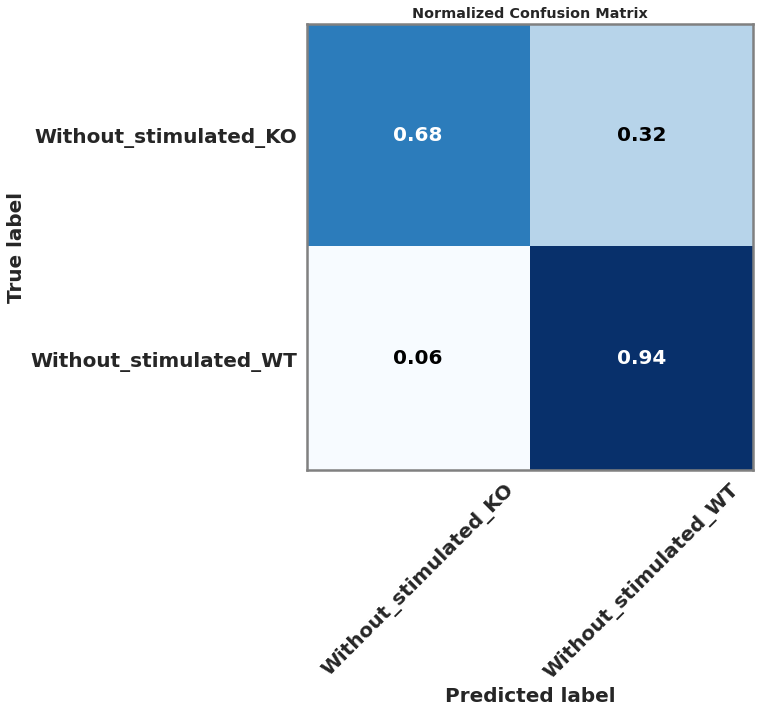

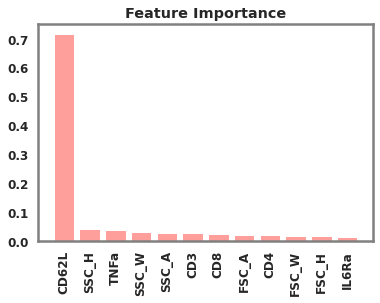

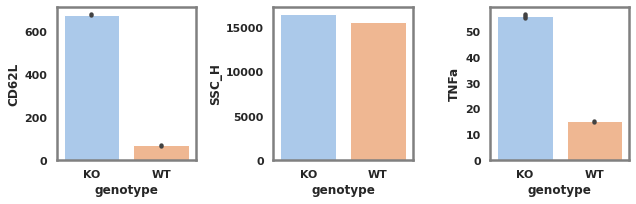

                       precision    recall  f1-score   support

Without_stimulated_KO       0.87      0.68      0.76    107827
Without_stimulated_WT       0.84      0.94      0.89    187386

             accuracy                           0.85    295213
            macro avg       0.85      0.81      0.83    295213
         weighted avg       0.85      0.85      0.84    295213



In [70]:
xgb_clf_rest_test = XGBClassifier(n_jobs = -1,random_state=42)
pop_model2(df_test_wo,["WT","KO"],"rest",numeric_features, "label2", xgb_clf_rest_test,3)